# NYC High School Data

In this project, I examine the relationship between SAT scores and various characteristics of responses collected in [a survey of parents, teachers, and students](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) in NYC high schools.

# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/var/folders/t1/v89h6wh530bcllc9545896xr0000gn/T/ipykernel_43899/3674931809.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

/var/folders/t1/v89h6wh530bcllc9545896xr0000gn/T/ipykernel_43899/3398560250.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)
type(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


pandas.core.series.Series

# Plotting survey correlations

Make a bar plot of the correlations between `sat_score` and the fields that came from [a survey of parents, teachers, and students](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8). 

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
# what are the columns in combined
list(combined.columns)

['DBN',
 'SCHOOL NAME',
 'Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score',
 'sat_score',
 'SchoolName',
 'AP Test Takers ',
 'Total Exams Taken',
 'Number of Exams with scores 3 4 or 5',
 'Demographic',
 'School Name',
 'Cohort',
 'Total Cohort',
 'Total Grads - n',
 'Total Grads - % of cohort',
 'Total Regents - n',
 'Total Regents - % of cohort',
 'Total Regents - % of grads',
 'Advanced Regents - n',
 'Advanced Regents - % of cohort',
 'Advanced Regents - % of grads',
 'Regents w/o Advanced - n',
 'Regents w/o Advanced - % of cohort',
 'Regents w/o Advanced - % of grads',
 'Local - n',
 'Local - % of cohort',
 'Local - % of grads',
 'Still Enrolled - n',
 'Still Enrolled - % of cohort',
 'Dropped Out - n',
 'Dropped Out - % of cohort',
 'CSD',
 'NUMBER OF STUDENTS / SEATS FILLED',
 'NUMBER OF SECTIONS',
 'AVERAGE CLASS SIZE',
 'SIZE OF SMALLEST CLASS',
 'SIZE OF LARGEST CLASS',
 'SCHOOLWIDE PUPIL-TEACHER RATIO',
 'Name',

In [13]:
# these are the fields that came from the survey mentioned above. 
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


<AxesSubplot: >

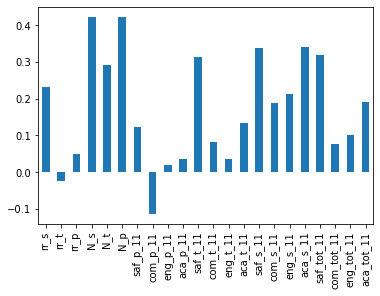

In [14]:
%matplotlib inline 
# set up matplotlib to work in Jupyter notebook

correlations[survey_fields].plot.bar()

There are high positive correlations between `sat_score`, and `N_s`(number of student respondents) and `N_p` (numnber of parent respondents). This might indicate that schools with a high enrollment (leading to a large number of student and parent respondents) have a high SAT score. 

furthermore, `rr_s`, the student response rate, or the percentage of students that completed the survey, positively correlates with `sat_score`. This may indicate that students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (`saf_t_11` and `saf_s_11`) positively correlate with `sat_score`. This make sense, as it's hard to teach or learn in an unsafe environment.

Finally, `aca_s_11`, which indicates how the student perceives academic standards, correlates positively with `sat_score`, but this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.

## Dig into the relationship between `sat_score` and `saf_t_11` / `saf_s_11` (how teachers and students perceive safety at school).

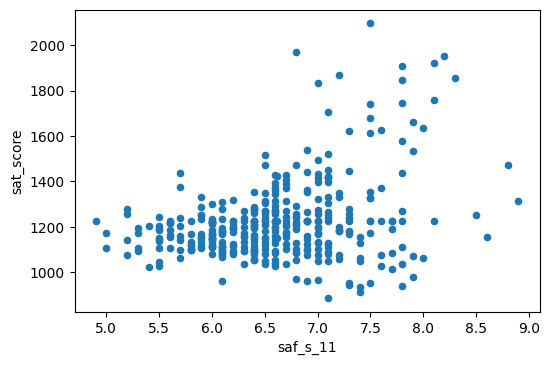

In [15]:
# make a scatter plot
%matplotlib inline 
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')

In [15]:
# compute the average safety score for each borough. 
combined.groupby(['boro'])['saf_s_11'].mean()

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

The average safefy score is similar across boroughs (min: 6.47, max: 6.83), and Manhattan has the highest safety score. 

## Investigate racial differences in SAT scores
There are a few columns that indicate the percentage of each race at a given school:
- `white_per`
- `asian_per`
- `black_per`
- `hispanic_per`

Make a plot of the correlations between these columns and `sat_score`

<AxesSubplot: >

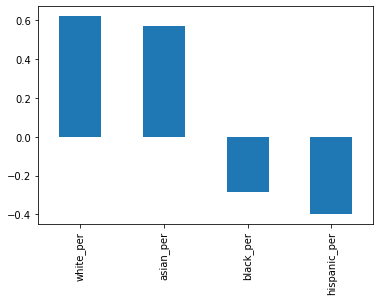

In [16]:
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

%matplotlib inline 

correlations[race_fields].plot.bar()

There is a positive correlation between:
- `sat_score` and `white_per`
- `sat_score` and `asian_per`
This indicates that a school with a higher percentage of white and asian race has a higher SAT score.

There is a negative correlation between:
- `sat_score` and `black_per`
- `sat_score` and `hispanic_per`
This indicates that a school with a higher percentage of black and hispanic race has a lower SAT score.

Explore `hispanic_per`

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='hispanic_per', ylabel='sat_score'>

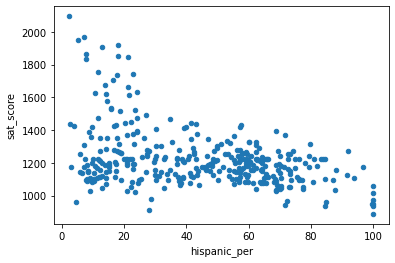

In [17]:
%matplotlib inline 
combined.plot.scatter(x = 'hispanic_per', y = 'sat_score')

The plot does indicate that as the `hispanic_per` (percentage of hispanic population in a school) increases, `sat_score` decreases. However, there are `sat_score`s higher than 1600 for `hispanic_per` range of 0-20% though this disappers for a higher `hispanic_per`, suggesting thate the negative correlation between `hispanic_per` and `sat_score` may be driven by the schools with `hispanic_per` greater than 20%. 

Researh schools with a `hispanic_per` greater than `95%`

In [18]:
hispanic_95_df = combined[combined['hispanic_per'] > 95]
hispanic_95_names = hispanic_95_df['SCHOOL NAME']
hispanic_95_names

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

At a first glance, the schools listed above appear to primarily be geared towards recent immigrants to the US. If these schools have a lot of students who are learning English, that could the lower SAT scores.

Researh schools with a `hispanic_per` less than `10%` and an average SAT score greater than `1800`

In [19]:
hispanic_10_df = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
hispanic_10_names = hispanic_10_df['SCHOOL NAME']
hispanic_10_names

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

At a first glance, these schools seem to be primarily greared towards science and technology. It is possible thate these schools have entrance exams and admit only the students who pass the exams, which could explain the relatively high SAT scores. 

## Investigate gender differences in SAT scores

<AxesSubplot: >

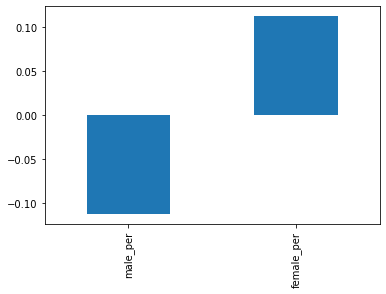

In [20]:
correlations[['male_per', 'female_per']].plot.bar()

There is no strong correlation between `sat_score` and percentage of male students (`male_per`), or between `sat_score` and percentage of female students (`female_per`). However, directionality of the correlation is different such that higher percentage of female population is associated with higher SAT score while the relationship  is the opposite for the male percentage and SAT score.

<AxesSubplot: xlabel='female_per', ylabel='sat_score'>

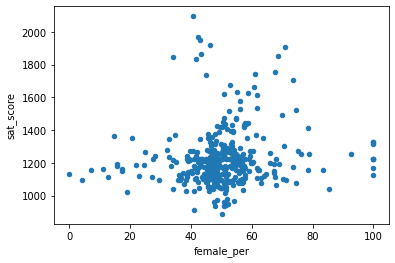

In [21]:
combined.plot.scatter(x = 'female_per', y = 'sat_score')

The plot indicates that the female percentage is concentrated between 40-60%.

Research schools with a `female_per` greater than `60%` and an average SAT score greater than `1700`

In [22]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools seems to be liberal arts schools.

## Relationship between Advanced Placement (AP) and SAT scores

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores.

First, calculate the percentage of students in each school that took an AP exam, and then investigte the relationship between AP scores and SAT scores. 

In [23]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

<AxesSubplot: xlabel='ap_per', ylabel='sat_score'>

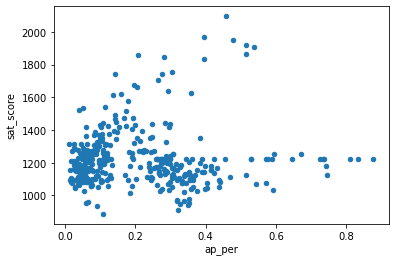

In [24]:
combined.plot.scatter(x = 'ap_per', y = 'sat_score')

In [25]:
# What is the correlation coefficient?
combined['sat_score'].corr(combined['ap_per'])

0.05717081390766968

There is close to no relationship betweeen the percentage of students in each school that took an AP exam (`ap_per`) and SAT scores (`sat_score`). The scatterplot shows that there are two clusters of schools: schools with `ap_per` between `0` and `0.2` and with `sat_score` between `1000` and `1400`, and schools with `ap_per` between `0.3` and `0.4` and with `sat_score` less than `1200`.